# Car Fuel Analysis

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pathlib import Path

## Loading Data

Important notes about the data:
- `Driving Style` refers to the previous driving inbetween the last date of fill up and the recorded date.

In [158]:
fuel = pd.read_csv('fuel.csv')

## Data Cleaning

In [159]:
fuel.head(3)

,Date,Mileage,Liters,PPL,Fuel Type,Price,Filled Tank,Driving Style,Roof Racks
0,20/12/2022,"47,671",22.44,139.9,E10,31.39,Y,Motorway,Y
1,24/12/2022,"47,894",24.75,138.9,E10,34.38,Y,Normal,Y
2,02/01/2023,"48,133",27.43,139.9,E10,38.37,Y,Motorway,Y


Reformating variables names into snake case.

In [160]:
fuel.columns = ['_'.join(col.lower().split()) for col in fuel.columns]

Converting the `date` column to a datetime.

In [161]:
fuel["date"] = pd.to_datetime(fuel["date"], format="%d/%m/%Y")

Converting `mileage` to numeric and renaming to `total_mileage`.

In [162]:
fuel["mileage"] = pd.to_numeric(fuel["mileage"].str.replace(",", ""))
fuel.rename(columns={'mileage': 'total_mileage'}, inplace=True)

~~Rename `ppl` to `price_per_liter`.~~

In [163]:
#fuel.rename(columns={'ppl': 'price_per_liter'}, inplace=True)

Convert `filled_tank` variable to boolean.

In [164]:
fuel["filled_tank"] = fuel["filled_tank"].map({"Y": True, "N": False})

Relabel `roof_rack` variables.

In [165]:
fuel["roof_racks"] = fuel["roof_racks"].replace({"Y": "On", "N": "Off"})

Replace `Supreme` with `SUP` in `fuel_type` column.

In [166]:
fuel["fuel_type"] = fuel["fuel_type"].replace("Supreme", "SUP")

Strip string columns of blank space.

In [188]:
for col in ("fuel_type", "driving_style"):
    fuel[col] = fuel[col].str.strip()

In [215]:
fuel = fuel.sort_values('date')

In [216]:
fuel

,date,total_mileage,liters,ppl,fuel_type,price,filled_tank,driving_style,roof_racks
0,2022-12-20,47671,22.44,139.9,E10,31.39,True,Motorway,On
1,2022-12-24,47894,24.75,138.9,E10,34.38,True,Normal,On
2,2023-01-02,48133,27.43,139.9,E10,38.37,True,Motorway,On
3,2023-01-08,48346,24.67,175.9,E10,43.39,True,Motorway,On
4,2023-01-09,48607,26.92,145.9,E10,39.28,True,Normal,On
5,2023-02-26,48775,22.18,140.9,E10,31.25,True,Mixed,On
6,2023-03-17,48869,10.91,174.9,E5,19.08,True,Normal,On
7,2023-03-17,49091,22.53,167.9,E10,37.83,True,Motorway,On
8,2023-03-18,49257,19.11,139.9,E10,26.73,True,Motorway,On
9,2023-03-25,49453,21.48,139.9,E10,30.05,True,Normal,On


Save `fuel` as `fuel_processed.csv`.

In [332]:
fuel.to_csv('fuel_processed.csv', index=False)

### Processing Fuel Data

- Aggregate instances where the tank was not filled.
- Compute the distance travelled on the fuel put in.

This will allow us to do efficiency analysis.

In [214]:
def process_fuel_data(fuel_df):
    df = fuel_df.copy()
    
    for index, row in fuel_df.iterrows():
        # pass any columns with a filled tank
        if row['filled_tank']:
            continue
        
        # drop final row and raise error
        if index == df.index[-1]:
            df.drop(index, inplace=True)
            warnings.warn("The final entry had filled_tank = False, so data was lost in processing")
            continue
        
        # update next column in data frame
        for col in ('liters', 'price'):
            df.at[index + 1, col] += row[col] 
        
        df.at[index + 1, 'ppl'] = (100*(df.at[index + 1, 'price'] / df.at[index + 1, 'liters'])).round(1)
        
        for col in ('fuel_type', 'driving_style', 'roof_racks'):
            if df.at[index + 1, col] != row[col]:
                df.at[index + 1, col] = "Mixed"
        
        #drop column
        df.drop(index, inplace=True)
    
    #computes mileage and miles_per_liter
    df['mileage'] = df['total_mileage'].diff()
    df['miles_per_liter'] = df['mileage'] / df['liters']
    
    return(df.reset_index(drop=True).sort_values('date'))

In [191]:
fuel2 = process_fuel_data(fuel)

In [192]:
fuel2.head()

,date,total_mileage,liters,ppl,fuel_type,price,filled_tank,driving_style,roof_racks,mileage,miles_per_liter
0,2022-12-20,47671,22.44,139.9,E10,31.39,True,Motorway,On,NaN,NaN
1,2022-12-24,47894,24.75,138.9,E10,34.38,True,Normal,On,223.0,9.010101
2,2023-01-02,48133,27.43,139.9,E10,38.37,True,Motorway,On,239.0,8.713088
3,2023-01-08,48346,24.67,175.9,E10,43.39,True,Motorway,On,213.0,8.633968
4,2023-01-09,48607,26.92,145.9,E10,39.28,True,Normal,On,261.0,9.695394


Save `fuel2` as `fuel_mpl.csv`.

In [331]:
fuel2.to_csv('fuel_mpl.csv', index=False)

## Analysis

In [248]:
#For saving figures
IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Mileage

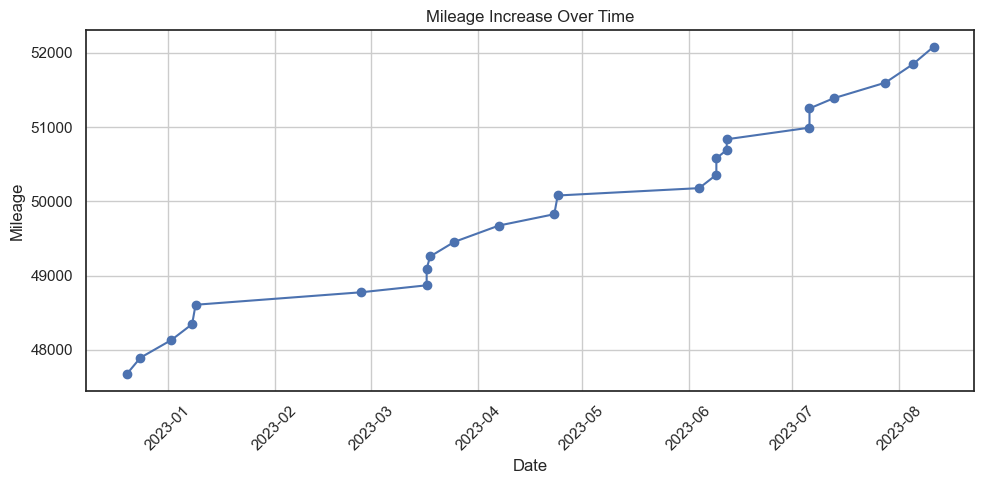

In [260]:
plt.figure(figsize=(10, 5))

plt.plot(fuel['date'], fuel['total_mileage'], marker='o', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Mileage')
plt.title('Mileage Increase Over Time')
plt.grid(True)
plt.xticks(rotation=45)

save_fig("mileage")
plt.show()

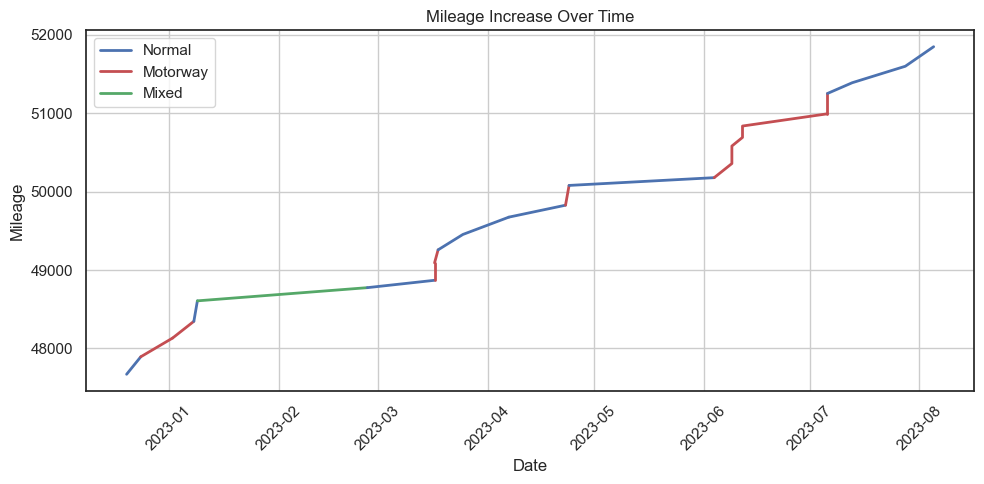

In [261]:
color_dict = {
    'Normal': '#4C72B0',
    'Motorway': '#C44E52',
    'Mixed': '#55A868'
}

plt.figure(figsize=(10, 5))

current_style = fuel['driving_style'].iloc[1]
line_color = color_dict[current_style]  # Initialize line color
x_points = [fuel['date'].iloc[0]]
y_points = [fuel['total_mileage'].iloc[0]]
legend_handles = {}

for i in range(1, len(fuel)-1):
    if fuel['driving_style'].iloc[i+1] == current_style:
        x_points.append(fuel['date'].iloc[i])
        y_points.append(fuel['total_mileage'].iloc[i])
    else:
        plt.plot(x_points, y_points, color=line_color, label=current_style, linewidth=2)  # Increase linewidth
        plt.plot([x_points[-1], fuel['date'].iloc[i]], [y_points[-1], fuel['total_mileage'].iloc[i]], color=line_color, linewidth=2)  # Increase linewidth
        legend_handles[current_style] = plt.Line2D([0], [0], color=line_color, linestyle='-', linewidth=2)  # Increase linewidth
        
        current_style = fuel['driving_style'].iloc[i+1]
        line_color = color_dict[current_style]  # Update line color
        x_points = [fuel['date'].iloc[i]]
        y_points = [fuel['total_mileage'].iloc[i]]
        
plt.plot(x_points, y_points, color=line_color, label=current_style, linewidth=2)  # Increase linewidth
legend_handles[current_style] = plt.Line2D([0], [0], color=line_color, linestyle='-', linewidth=2)  # Increase linewidth

plt.xlabel('Date')
plt.ylabel('Mileage')
plt.title('Mileage Increase Over Time')
plt.legend(handles=legend_handles.values(), labels=legend_handles.keys())
plt.grid(True)
plt.xticks(rotation=45)

save_fig("mileage_colored_by_driving_style")
plt.show()

### Fuel Prices

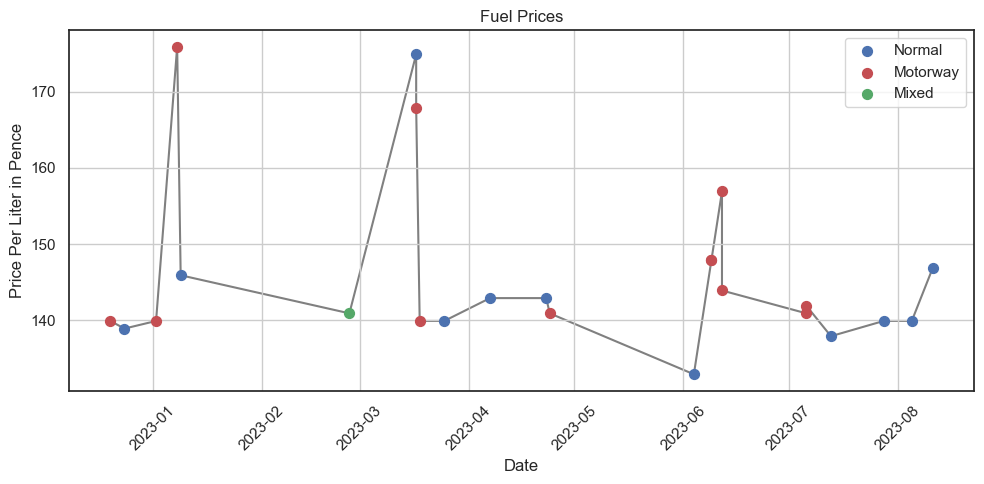

In [292]:
color_dict = {
    'Normal': '#4C72B0',
    'Motorway': '#C44E52',
    'Mixed': '#55A868'
}

plt.figure(figsize=(10, 5))

for style in color_dict:
    mask = fuel['driving_style'] == style
    plt.scatter(fuel['date'][mask], fuel['ppl'][mask], marker='o', s=50, color=color_dict[style], label=style)

plt.plot(fuel['date'], fuel['ppl'], marker='', linestyle='-', color="grey", zorder=0)

plt.xlabel('Date')
plt.ylabel('Price Per Liter in Pence')
plt.title('Fuel Prices')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

save_fig("fuel_prices")
plt.show()


### Fuel Efficiency

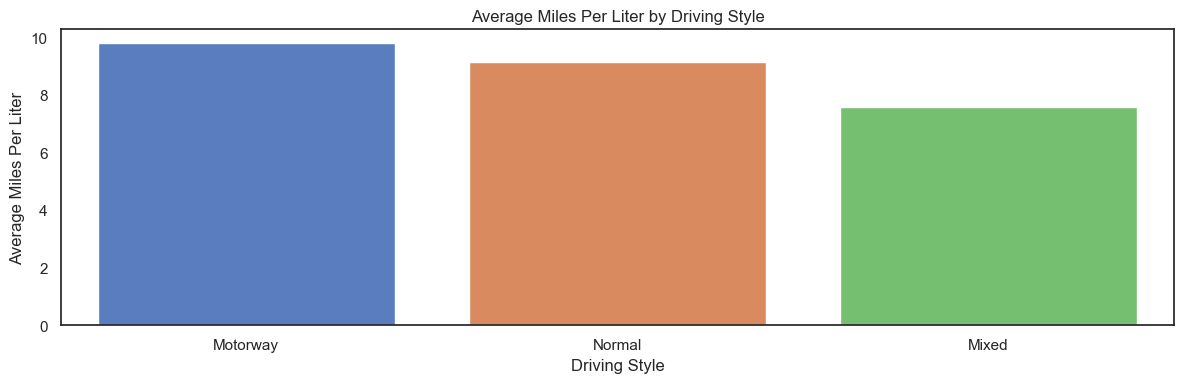

In [310]:
sns.set_palette("muted")  # Change "Set2" to the desired palette

# Plot 1 - Driving Style
plt.figure(figsize=(12, 4))

sns.barplot(data=fuel2, x='driving_style', y='miles_per_liter', ci=None)
plt.xlabel('Driving Style')
plt.ylabel('Average Miles Per Liter')
plt.title('Average Miles Per Liter by Driving Style')

save_fig("fuel_efficiency_by_driving_style")
plt.show()

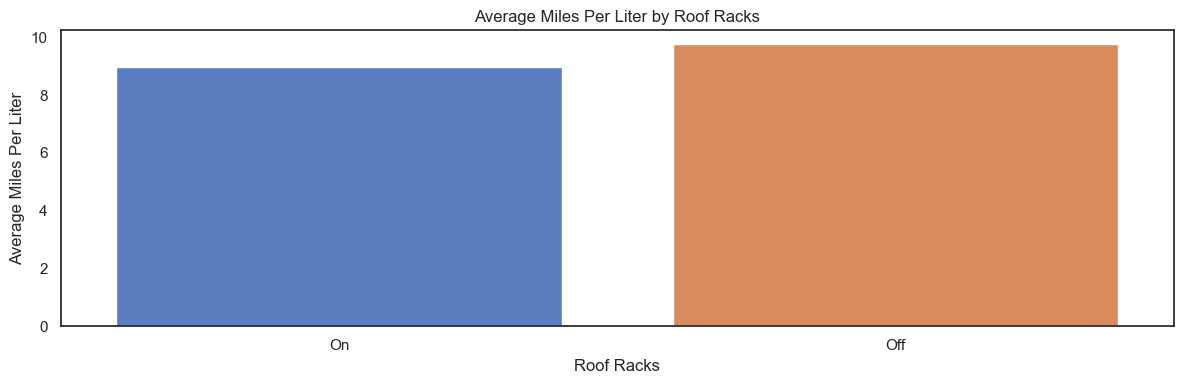

In [311]:
# Plot 2 - Roof Racks
plt.figure(figsize=(12, 4))

sns.barplot(data=fuel2, x='roof_racks', y='miles_per_liter', ci=None)
plt.xlabel('Roof Racks')
plt.ylabel('Average Miles Per Liter')
plt.title('Average Miles Per Liter by Roof Racks')

save_fig("fuel_efficiency_by_roof_racks")
plt.show()

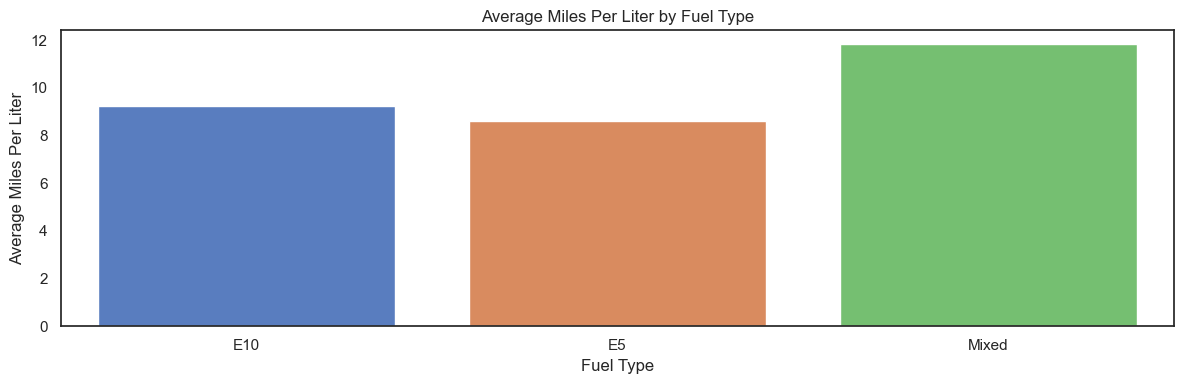

In [312]:
# Plot 3 - Fuel Type
plt.figure(figsize=(12, 4))

sns.barplot(data=fuel2, x='fuel_type', y='miles_per_liter', ci=None)
plt.xlabel('Fuel Type')
plt.ylabel('Average Miles Per Liter')
plt.title('Average Miles Per Liter by Fuel Type')

save_fig("fuel_efficiency_by_fuel_type")
plt.show()

## Tools and Utilities

Function to calculate cost of journey based on distance and fuel price with option to filter by fuel type, roof rack and/or driving style.

In [329]:
def journey_cost(distance, ppl, data=fuel2, roof_racks=None, fuel_type=None, driving_style=None):
    df = data.copy()
    
    for var, name in ((roof_racks, 'roof_racks'),
                      (fuel_type, 'fuel_type'),
                      (driving_style, 'driving_style')):
        if var != None:
            df = df[(df[name] == var)]
            
    average_miles_per_liter = df['miles_per_liter'].mean()
    
    liters = distance / average_miles_per_liter
    price = liters * ppl / 100
    
    print(f"AVG MPL: {average_miles_per_liter:.4f} mpl")
    print(f"DIST: {distance} mi")
    print(f"LITERS: {liters:.1f} l")
    print(f"\033[1mPrice: £{price:.2f}")

In [330]:
journey_cost(350, 149.9)

AVG MPL: 9.3427 mpl
DIST: 350 mi
LITERS: 37.5 l
Price: £56.16
